# Algoritmos de Previsão Temporal

## Setup do Projeto

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy
import itertools
from pmdarima import auto_arima
import statsmodels.api as sm
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("inflacao.csv")

In [4]:
df.describe()

,ano,mes,ano_mes,ipca_variacao,ipca_acumulado_ano,ipca_acumulado_doze_meses,ipca15_variacao,ipca15_acumulado_ano,ipca15_acumulado_doze_meses,inpc_variacao,inpc_acumulado_ano,inpc_acumulado_doze_meses,ipa_variacao,ipa_acumulado_ano,ipc_fipe_variacao,ipc_fipe_acumulado_ano,incc_variacao,incc_acumulado_ano
count,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000
mean,2000.959223,6.489320,200102.411650,5.948214,96.495709,310.089010,0.269767,1.855107,3.380874,5.937029,95.998350,309.124350,6.172835,41.392097,5.787243,38.828136,6.107126,41.928485
std,12.399177,3.450227,1239.904297,10.862122,265.975237,864.719013,0.392667,2.413151,3.815471,10.868282,263.216087,850.787432,11.046885,73.768541,10.778574,72.750950,11.219681,73.801160
min,1980.000000,1.000000,198001.000000,-0.680000,-0.160000,0.000000,-0.730000,0.000000,0.000000,-0.600000,0.060000,0.000000,-2.420000,-5.820000,-1.000000,-1.790000,-0.500000,0.310000
25%,1990.000000,3.500000,199009.500000,0.380000,2.485000,5.250000,0.000000,0.000000,0.000000,0.385000,2.585000,5.405000,0.265000,2.215000,0.300000,1.995000,0.360000,2.900000
50%,2001.000000,6.000000,200106.000000,0.780000,5.230000,7.770000,0.050000,0.650000,2.800000,0.820000,5.210000,9.030000,1.360000,7.550000,0.740000,4.910000,0.880000,6.560000
75%,2012.000000,9.000000,201202.500000,6.840000,49.070000,156.790000,0.485000,3.265000,6.205000,6.755000,46.755000,161.665000,7.315000,43.015000,6.720000,39.500000,6.030000,45.915000
max,2022.000000,12.000000,202211.000000,82.390000,2477.150000,6821.310000,3.050000,11.990000,17.240000,82.180000,2489.110000,6554.520000,82.040000,381.830000,79.110000,374.660000,78.410000,388.770000


In [5]:
df.head()

,referencia,ano,mes,ano_mes,ipca_variacao,ipca_acumulado_ano,ipca_acumulado_doze_meses,ipca15_variacao,ipca15_acumulado_ano,ipca15_acumulado_doze_meses,inpc_variacao,inpc_acumulado_ano,inpc_acumulado_doze_meses,ipa_variacao,ipa_acumulado_ano,ipc_fipe_variacao,ipc_fipe_acumulado_ano,incc_variacao,incc_acumulado_ano,consolidado_ano
0,1980-01,1980,1,198001,6.62,6.62,0.0,0.0,0.0,0.0,6.56,6.56,0.00,7.31,7.31,4.48,4.48,4.70,4.70,False
1,1980-02,1980,2,198002,4.62,11.54,0.0,0.0,0.0,0.0,4.15,10.98,0.00,3.69,11.00,3.35,7.83,9.53,14.23,False
2,1980-03,1980,3,198003,6.04,18.27,0.0,0.0,0.0,0.0,5.12,16.67,75.11,6.32,17.32,4.34,12.17,12.80,27.03,False
3,1980-04,1980,4,198004,5.29,24.53,0.0,0.0,0.0,0.0,4.85,22.33,77.48,6.69,24.01,3.93,16.10,3.13,30.16,False
4,1980-05,1980,5,198005,5.70,31.63,0.0,0.0,0.0,0.0,5.53,29.10,84.06,7.32,31.33,6.52,22.62,4.86,35.02,False


# ARMA - Autoregressive Moving Average (ARMA)

O termo “autoregressivo” no ARMA significa que o modelo usa valores passados **para prever valores futuros**. Especificamente, os valores previstos são uma combinação linear ponderada de valores passados. Esse tipo de método de regressão é semelhante à regressão linear , com a diferença de que as entradas de recurso aqui são valores históricos. 

#### Formatando as Datas

In [6]:
df.index = pd.to_datetime(df['referencia'], format='%Y-%m-%d')

#### Pegando os dados somente de 1995 para o mais atual

In [7]:
df_recente = df[df['ano'] >= 1995]

In [8]:
df_recente = df_recente["ipca_variacao"]

In [9]:
df_recente.head()

referencia
1995-01-01    1.70
1995-02-01    1.02
1995-03-01    1.55
1995-04-01    2.43
1995-05-01    2.67
Name: ipca_variacao, dtype: float64

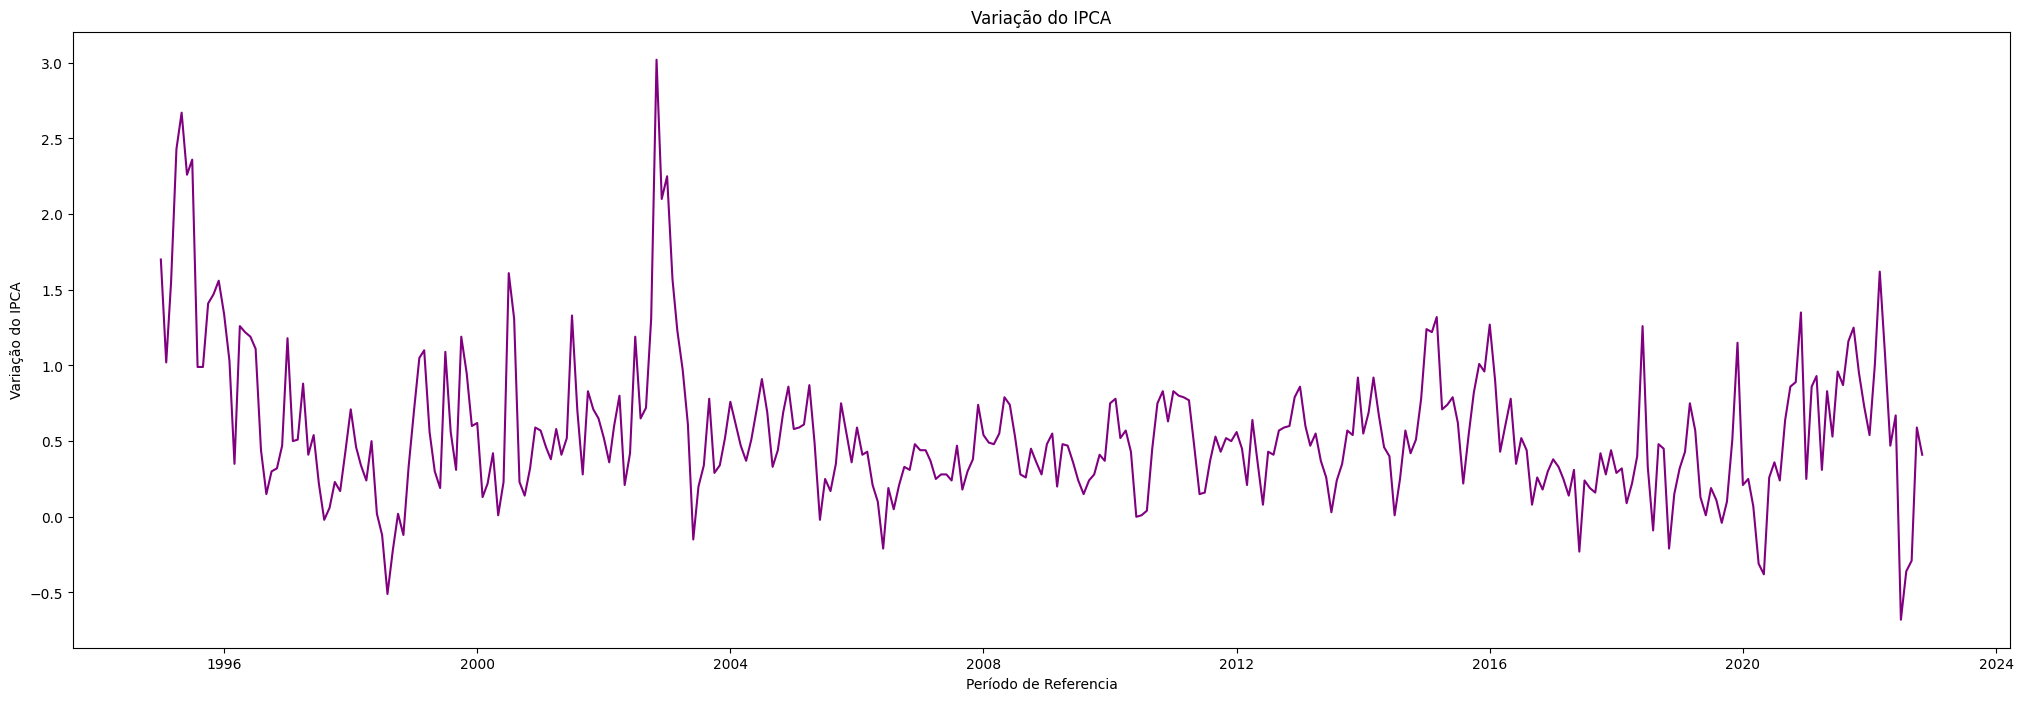

In [10]:
plt.figure(figsize=(25, 8))
plt.plot(df_recente, label="Variação do IPCA", color='purple')
plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")

plt.title("Variação do IPCA")

plt.show()

### Dividindo os dados para treinamento e teste

Uma parte importante da construção do modelo é dividir nossos dados para treinamento e teste, o que garante que você crie um modelo que possa generalizar fora dos dados de treinamento e que o desempenho e as saídas sejam estatisticamente significativos.

In [11]:
train = df_recente[df_recente.index <= pd.to_datetime("2022-06-01", format='%Y-%m-%d')]
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)

In [12]:
test = df_recente[df_recente.index >= pd.to_datetime("2022-06-01", format='%Y-%m-%d')]
test.index = pd.DatetimeIndex(test.index.values,
                               freq=test.index.inferred_freq)

In [13]:
train.shape

(330,)

In [14]:
test.shape

(6,)

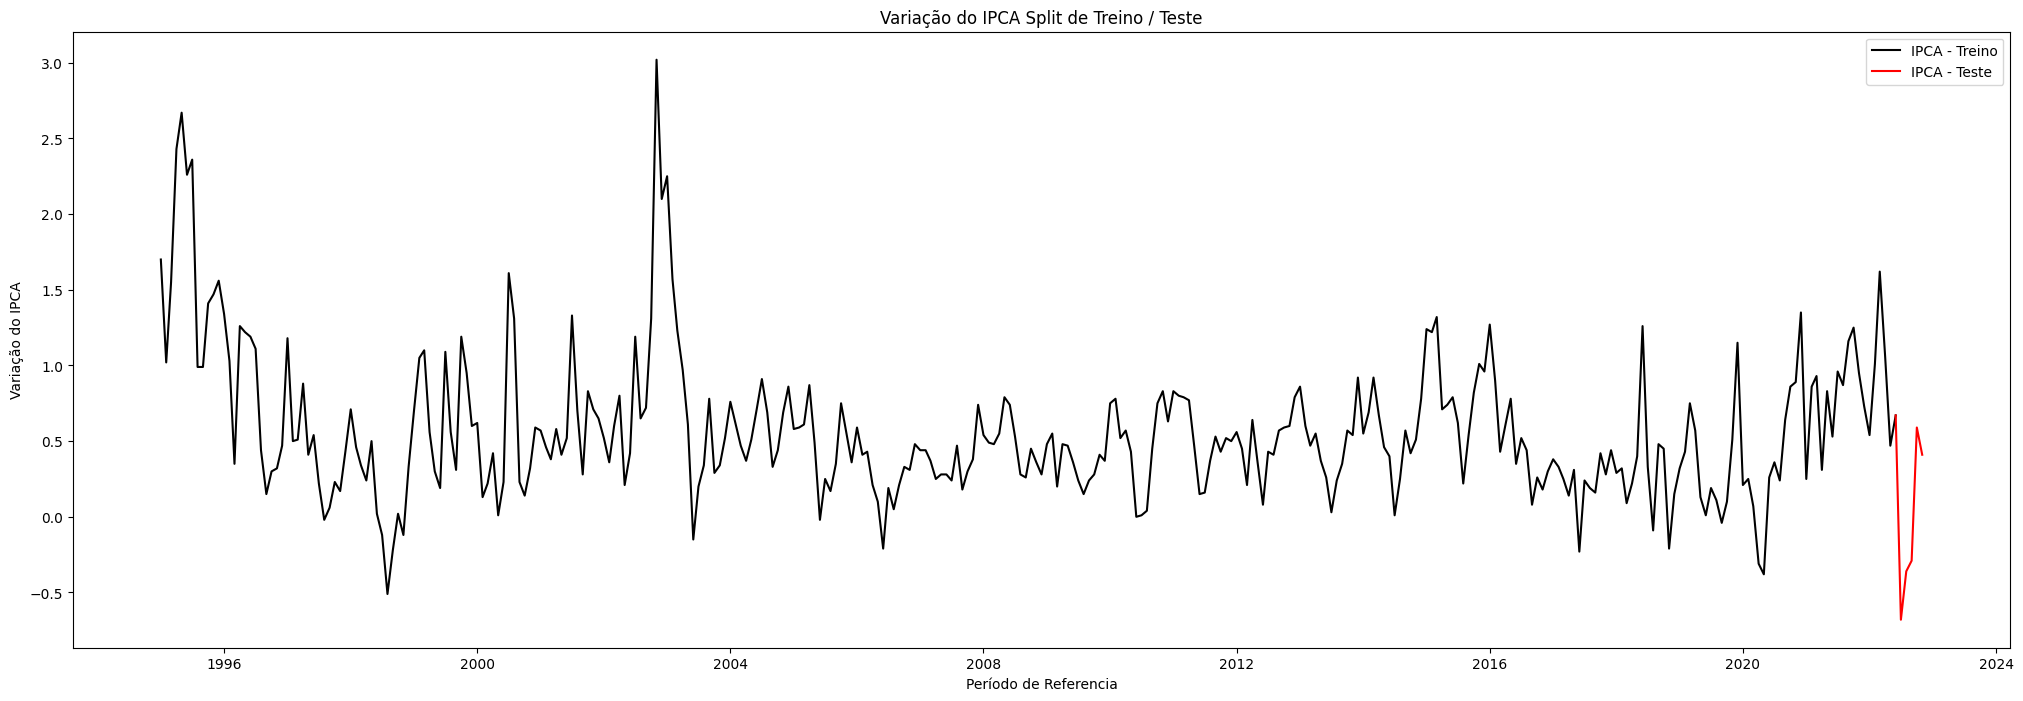

In [16]:
plt.figure(figsize=(25, 8))
plt.plot(train, label="IPCA - Treino", color='black')
plt.plot(test, label="IPCA - Teste", color='red')
plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")


plt.title("Variação do IPCA Split de Treino / Teste")
plt.legend()
plt.show()

Vamos utilizar o pacote `SARIMAX` para definir um modelo `ARMA`. 

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Definindo nossa entrada de dados

E então vamos definir nosso modelo. Para definir um modelo ARMA com a classe SARIMAX, passamos os parâmetros de ordem de (1, 0 ,1). Alpha corresponde ao nível de significância de nossas previsões. Normalmente, escolhemos um alfa = 0,05. Aqui, o algoritmo ARIMA calcula os limites superior e inferior em torno da previsão, de modo que haja 5% de chance de que o valor real esteja fora dos limites superior e inferior. Isso significa que há 95% de confiança de que o valor real estará entre os limites superior e inferior de nossas previsões.

In [21]:
ARMAmodel = SARIMAX(train, order = (2, 0, 2))

In [22]:
ARMAmodel = ARMAmodel.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39198D-01    |proj g|=  3.10450D-01

At iterate    5    f=  3.35370D-01    |proj g|=  2.42832D-02

At iterate   10    f=  3.33729D-01    |proj g|=  4.72376D-02

At iterate   15    f=  3.22099D-01    |proj g|=  9.94204D-03

At iterate   20    f=  3.15556D-01    |proj g|=  3.11708D-03

At iterate   25    f=  3.14703D-01    |proj g|=  7.01057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     35      1     0     0   

 This problem is unconstrained.


### Gerando as Previsões

In [23]:
y_pred = ARMAmodel.get_forecast(len(test.index))

In [24]:
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

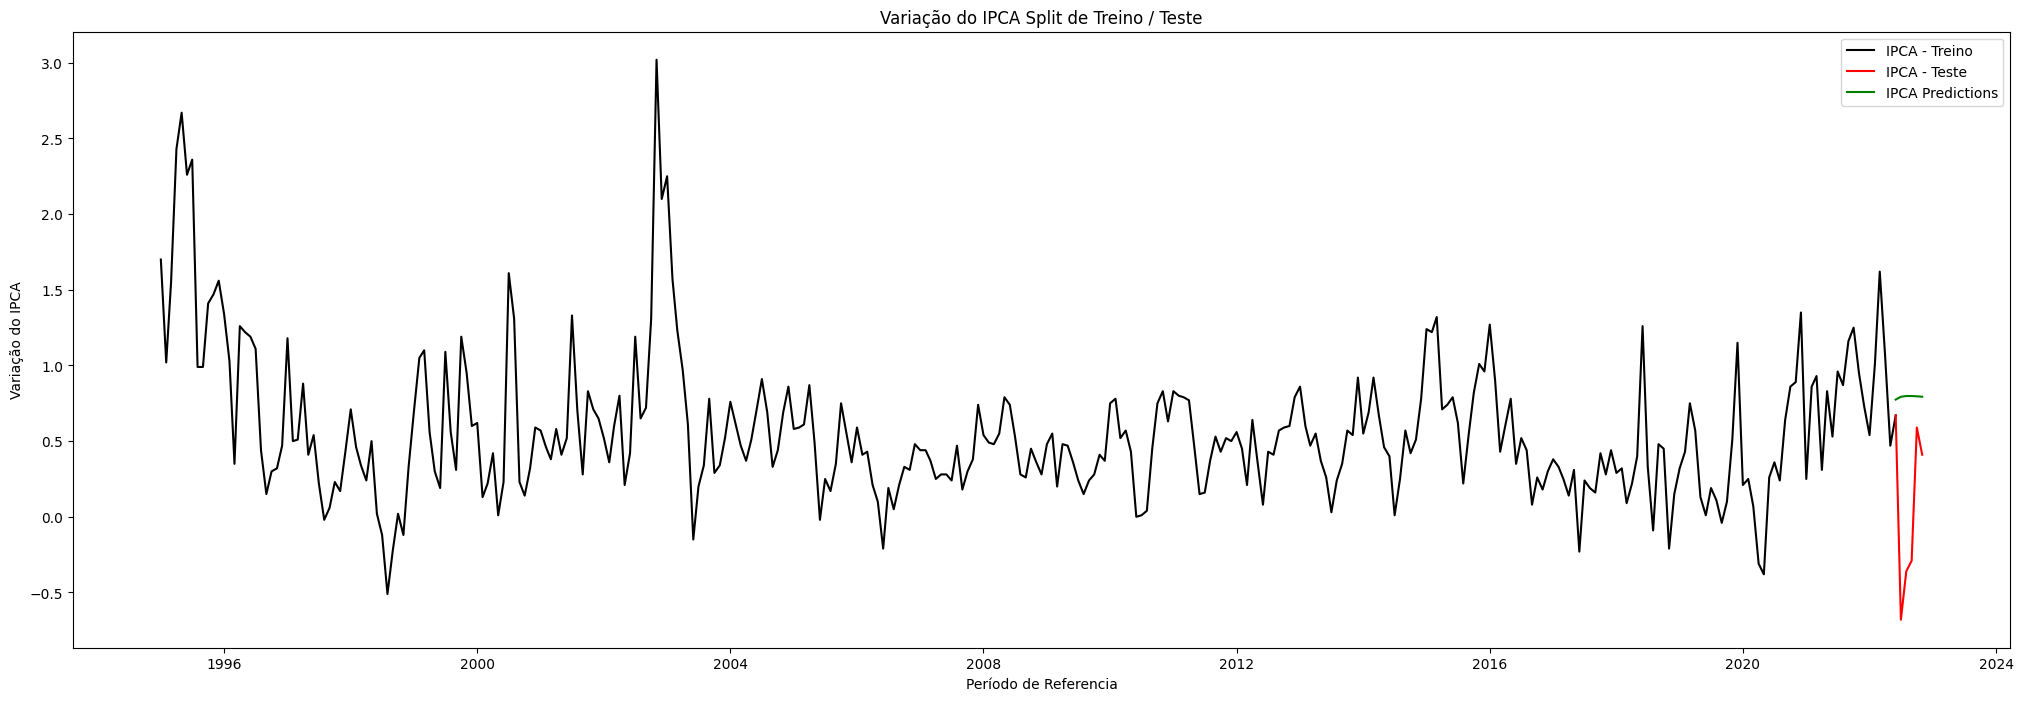

In [25]:
plt.figure(figsize=(25, 8))
plt.plot(train.index, train, label="IPCA - Treino", color='black')
plt.plot(test.index, test, label="IPCA - Teste", color='red')

plt.plot(y_pred_out, color='green', label = 'IPCA Predictions')

plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")

plt.title("Variação do IPCA Split de Treino / Teste")
plt.legend()
plt.show()

#### Também podemos avaliar o desempenho usando a raiz do erro quadrático médio:

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  0.9032911949246275


O RMSE é bastante baixo, o que poderíamos ter adivinhado ao inspecionar o terreno. Infelizmente, o modelo prevê uma queda no preço quando o preço realmente aumenta. Novamente, o ARMA é limitado porque falha para séries temporais não estacionárias e não captura a sazonalidade. Vamos ver se podemos melhorar o desempenho com um modelo ARIMA. 

# Média móvel integrada autorregressiva (ARIMA)

In [28]:
from statsmodels.tsa.arima.model import ARIMA

Uma tarefa ARIMA tem três parâmetros. O primeiro parâmetro corresponde ao atraso (valores passados), o segundo corresponde à diferenciação (é isso que torna os dados não estacionários estacionários) e o último parâmetro corresponde ao ruído branco (para modelar eventos de choque). 

Vamos definir um modelo ARIMA com parâmetros de ordem (2,2,0):

Defina o modelo chamando ARIMA () e passando os parâmetros p , d e q .
O modelo é preparado nos dados de treinamento chamando a função fit().
As previsões podem ser feitas chamando a função predict() e especificando o índice da hora ou horas a serem previstas.


Primeiro, ajustamos um modelo ARIMA(2,2,0). 
Isso define o valor de atraso como 2 para autorregressão, usa uma ordem de diferença de 2 para tornar a série temporal estacionária e usa um modelo de média móvel de 0.


In [29]:
ARIMAmodel = ARIMA(y, order = (2,2,0))
ARIMAmodel = ARIMAmodel.fit()

In [30]:
y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_arima = y_pred_df["Predictions"] 

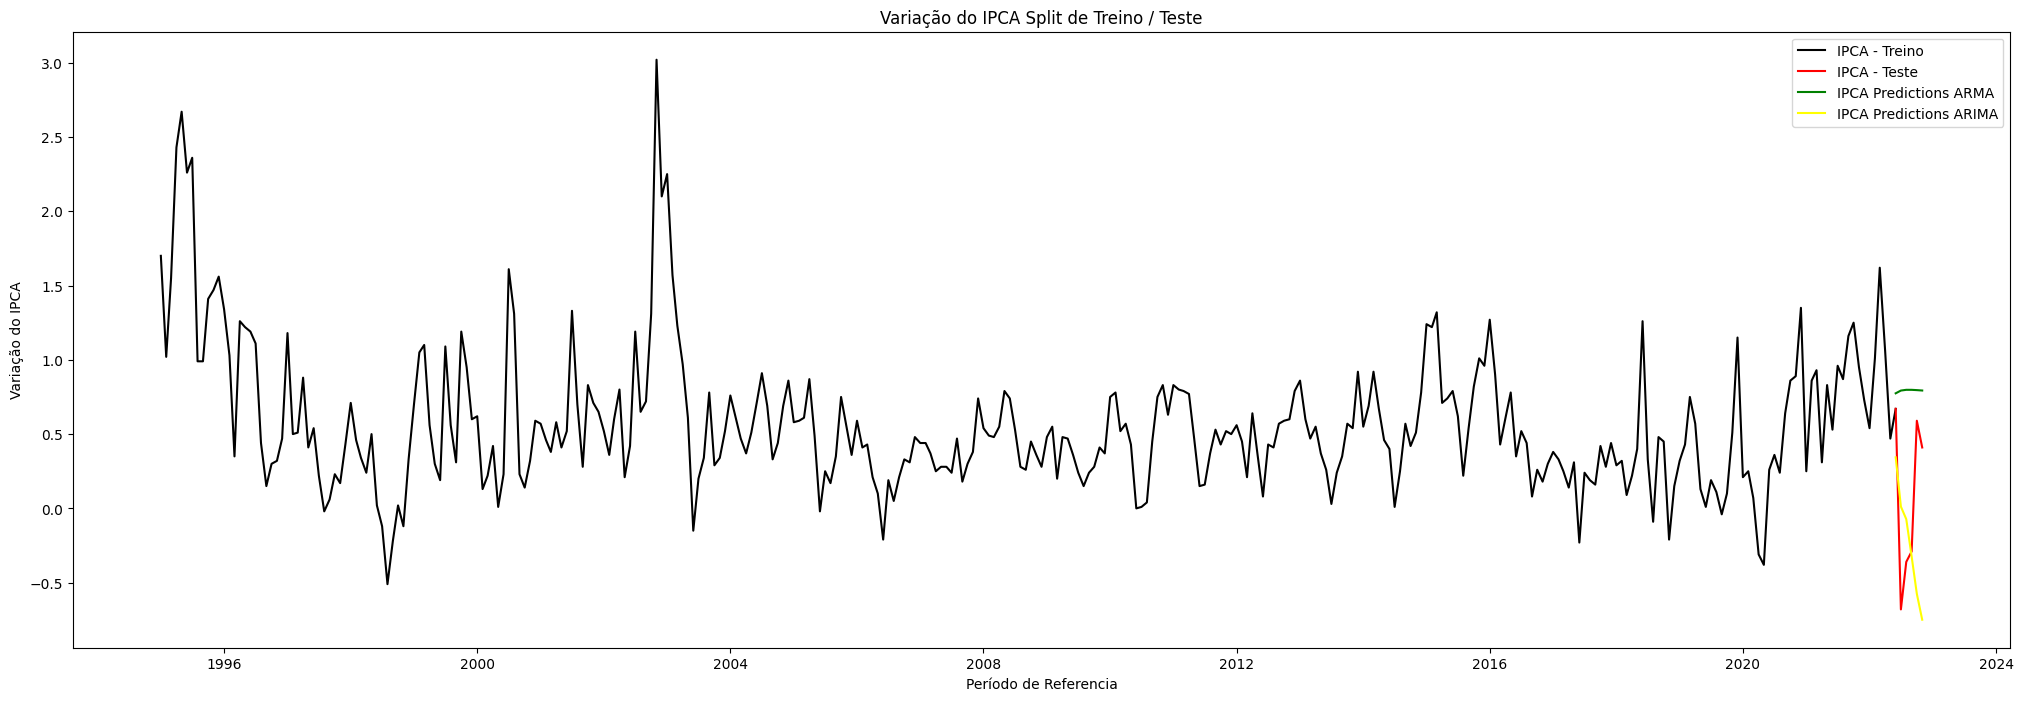

In [31]:
plt.figure(figsize=(25, 8))
plt.plot(train.index, train, label="IPCA - Treino", color='black')
plt.plot(test.index, test, label="IPCA - Teste", color='red')

plt.plot(y_pred_out, color='green', label = 'IPCA Predictions ARMA')
plt.plot(y_pred_out_arima, color='Yellow', label = 'IPCA Predictions ARIMA')

plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")


plt.title("Variação do IPCA Split de Treino / Teste")
plt.legend()
plt.show()

## Encotrando a melhor combinação para ARIMA

In [204]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [205]:
def evaluate_models(dataset, p_values, d_values, q_values):
# 	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)              
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [206]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

In [207]:
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 3)

In [214]:
m_arima = auto_arima(train, seasonal=True, traces=True, stepwises=False, m=12, max_p=6, max_q=6)

In [215]:
m_arima

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [216]:
m_arima.aic()

196.38402003063658

In [199]:
#evaluate_models(train, p_values, d_values, q_values)

#### Resultado do teste do modelo. 

O algoritmo acima foi comentado para melhorar a performance do modelo. 

```
ARIMA(0, 0, 0) RMSE=0.662
ARIMA(0, 0, 1) RMSE=0.522
ARIMA(0, 0, 2) RMSE=0.468
ARIMA(0, 1, 0) RMSE=0.481
ARIMA(0, 1, 1) RMSE=0.487
ARIMA(0, 1, 2) RMSE=0.495
ARIMA(0, 2, 0) RMSE=0.704
ARIMA(0, 2, 1) RMSE=0.484
ARIMA(0, 2, 2) RMSE=0.490
ARIMA(1, 0, 0) RMSE=0.452
ARIMA(1, 0, 1) RMSE=0.455
ARIMA(1, 0, 2) RMSE=0.460
ARIMA(1, 1, 0) RMSE=0.485
ARIMA(1, 1, 1) RMSE=0.461
ARIMA(1, 1, 2) RMSE=0.467
ARIMA(1, 2, 0) RMSE=0.625
ARIMA(1, 2, 1) RMSE=0.488
ARIMA(1, 2, 2) RMSE=0.507
ARIMA(2, 0, 0) RMSE=0.455
ARIMA(2, 0, 1) RMSE=0.452
ARIMA(2, 0, 2) RMSE=0.451
ARIMA(2, 1, 0) RMSE=0.484
ARIMA(2, 1, 1) RMSE=0.465
ARIMA(2, 1, 2) RMSE=0.479
ARIMA(2, 2, 0) RMSE=0.612
ARIMA(2, 2, 1) RMSE=0.487
ARIMA(2, 2, 2) RMSE=0.491
ARIMA(3, 0, 0) RMSE=0.458
ARIMA(3, 0, 1) RMSE=0.457
ARIMA(3, 0, 2) RMSE=0.464
ARIMA(3, 1, 0) RMSE=0.473
ARIMA(3, 1, 1) RMSE=0.473
ARIMA(3, 1, 2) RMSE=0.466
ARIMA(3, 2, 0) RMSE=0.554
ARIMA(3, 2, 1) RMSE=0.476
ARIMA(3, 2, 2) RMSE=0.518
ARIMA(4, 0, 0) RMSE=0.458
ARIMA(4, 0, 1) RMSE=0.463
ARIMA(4, 0, 2) RMSE=0.474
ARIMA(4, 1, 0) RMSE=0.483
ARIMA(4, 1, 1) RMSE=0.473
ARIMA(4, 1, 2) RMSE=0.492
ARIMA(4, 2, 0) RMSE=0.537
ARIMA(4, 2, 1) RMSE=0.486
ARIMA(4, 2, 2) RMSE=0.495
ARIMA(5, 0, 0) RMSE=0.460
ARIMA(5, 0, 1) RMSE=0.486
ARIMA(5, 0, 2) RMSE=0.501
ARIMA(5, 1, 0) RMSE=0.489
ARIMA(5, 1, 1) RMSE=0.474
ARIMA(5, 1, 2) RMSE=0.492
ARIMA(5, 2, 0) RMSE=0.529
ARIMA(5, 2, 1) RMSE=0.492
ARIMA(5, 2, 2) RMSE=0.502
ARIMA(6, 0, 0) RMSE=0.461
ARIMA(6, 0, 1) RMSE=0.481
ARIMA(6, 1, 0) RMSE=0.502
ARIMA(6, 1, 1) RMSE=0.500
ARIMA(6, 1, 2) RMSE=0.511
ARIMA(6, 2, 0) RMSE=0.546
ARIMA(6, 2, 1) RMSE=0.506
Best ARIMA(2, 0, 2) RMSE=0.451
```

In [32]:
ARIMAmodel = ARIMA(y, order = (1,1,1))
ARIMAmodel = ARIMAmodel.fit()

In [33]:
y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_arima = y_pred_df["Predictions"] 

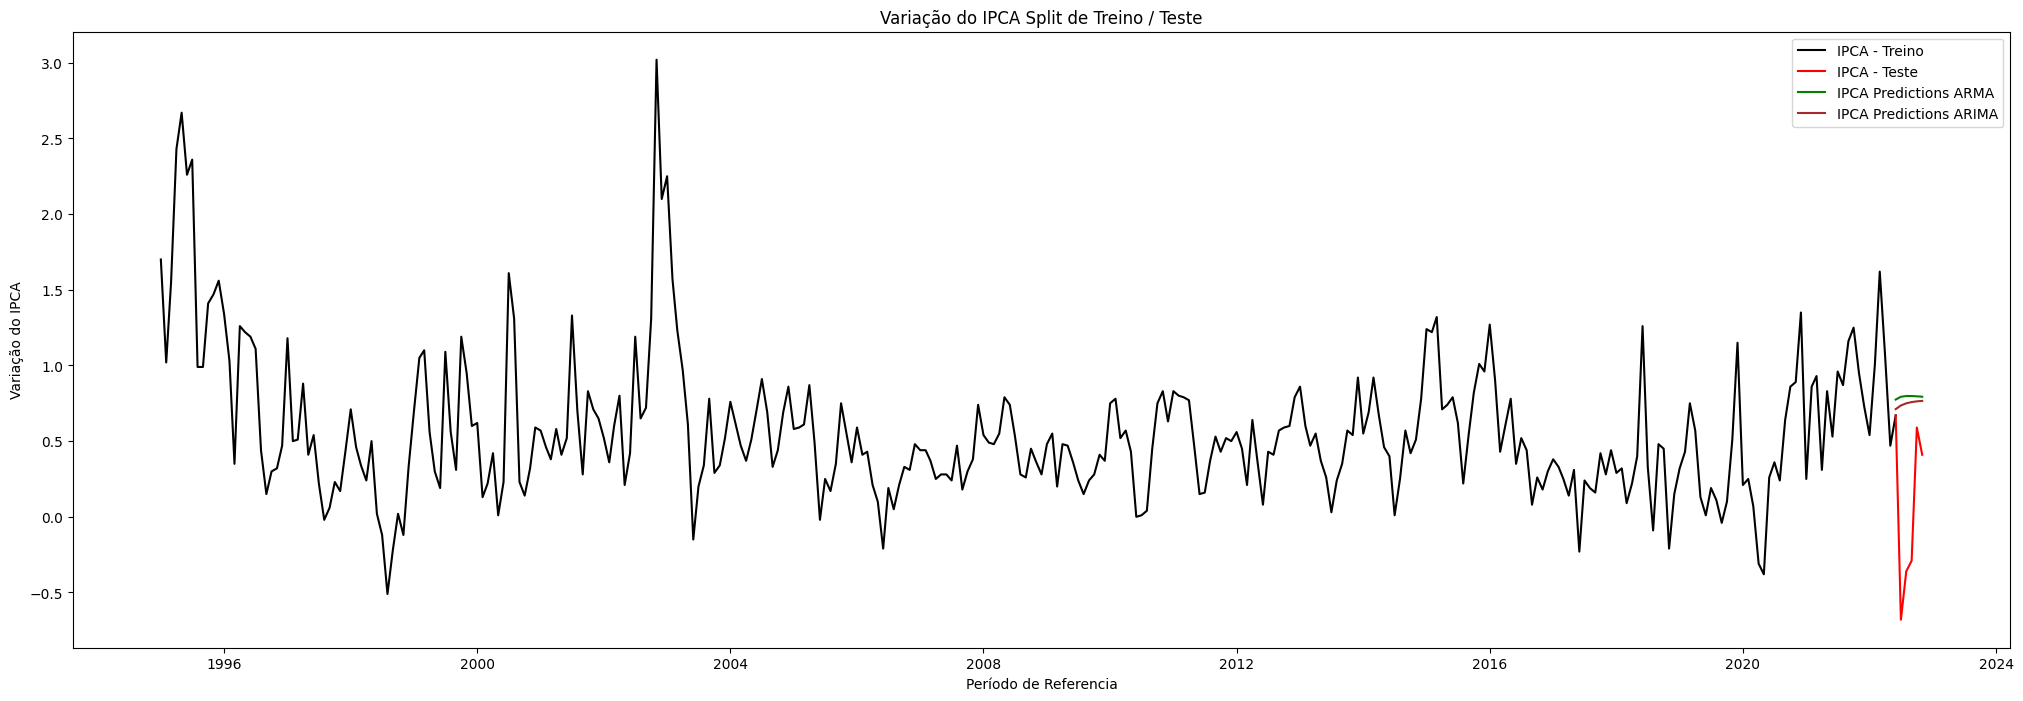

In [34]:
plt.figure(figsize=(25, 8))
plt.plot(train.index, train, label="IPCA - Treino", color='black')
plt.plot(test.index, test, label="IPCA - Teste", color='red')

plt.plot(y_pred_out, color='green', label = 'IPCA Predictions ARMA')
plt.plot(y_pred_out_arima, color='brown', label = 'IPCA Predictions ARIMA')

plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")


plt.title("Variação do IPCA Split de Treino / Teste")
plt.legend()
plt.show()

# ARIMA Sazonal (SARIMA)

O ARIMA sazonal captura valores históricos, eventos de choque e sazonalidade. Podemos definir um modelo SARIMA usando a classe SARIMAX:

### (P,D,Q,M) Ordem
A ordem `(P,D,Q,M)` de ordem sazonal refere-se ao componente sazonal do modelo para os parâmetros auto regressivos, diferenças, parâmetros de média móvel e periodicidade:

* D indica a ordem de integração do processo sazonal (o número de transformações necessárias para tornar estacionária a série temporal)
* P indica a ordem regressiva automática para o componente sazonal
* Q indicou a ordem da Média Móvel para o componente sazonal
* M indica a periodicidade, ou seja, o número de períodos na temporada, como 12 para dados mensais.

### Encontrando os Valores da Ordem Sazonal

#### Encontrando a decomposição sazonal para definir a série temporal

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [36]:
result = seasonal_decompose(train, model='additive',extrapolate_trend='freq')

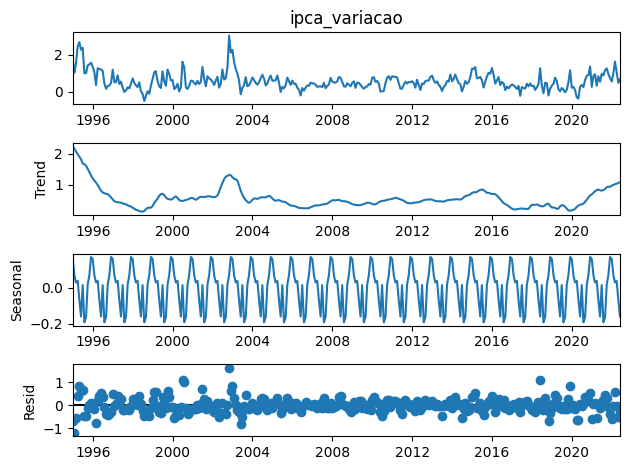

In [37]:
result.plot()
plt.show()

In [38]:
from statsmodels.tsa.stattools import adfuller

In [39]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [40]:
seasonal = result.seasonal
check_stationarity(seasonal)

The series is stationary


In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

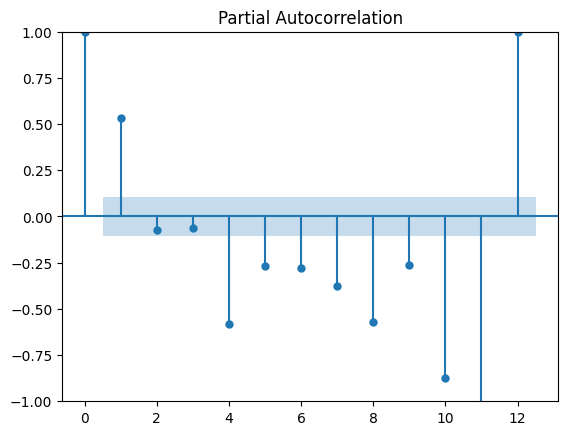

In [42]:
plot_pacf(seasonal, lags =12)
plt.show()


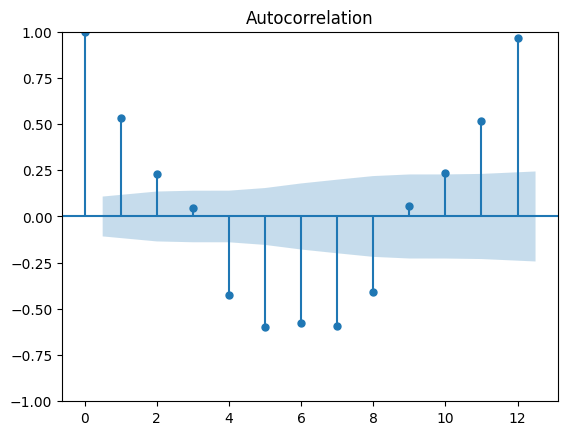

In [43]:
plot_acf(seasonal, lags=12)
plt.show()

In [44]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [45]:
sarima_scores = pd.DataFrame()

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit(disp=False)
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            sarima_scores = sarima_scores.append({'Param': param, 'Param_Seasonal': param_seasonal, 'AIC': results.aic}, ignore_index=True)
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:724.4009938321196
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:520.41890235032
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:464.5648904238233
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:503.72697260963804
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:394.668319165101
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:312.09041595714604
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:762.6871983080744
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:507.98996706073564
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:447.3029803858336
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:423.01701189008696
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:416.15561895097085
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:327.82382224966915
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:423.8631434035286
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:326.28629696682674
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:313.28684157897715
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:602.343079438403
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:457.4383975033618
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:381.70878444363916
ARIMA

ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:189.1369048875951
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:183.1152070617762
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:480.7622951192015
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:301.60871172252376
ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:237.91645815139464
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:166.92878348120973
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:167.31964838753578
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:166.97951551571987
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:224.54511915115626
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:182.94956457379084
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:182.03606754749734
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:387.2220550569511
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:264.1808630760214
ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:249.8666677767982
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:524.0675453093727
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:483.7813051529132
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:453.6505037628132
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:628.8440935630871
AR

ARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:237.51276965477572
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:207.84601254425607
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:176.61566712283786
ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:166.53737522415352
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:313.6392222314748
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:179.16130498107515
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:167.0063544943266
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:608.3596257634604
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:335.0047232112499
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:224.78249344520788
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:174.15472507955334
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:167.2378066101224
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:163.53216052514
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:244.10322183678983
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:173.00945977664384
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:168.9543181654237
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:453.2276400371769
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:283.0973742319194
ARI

ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:297.04213486959355
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:233.71380268409752
ARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:226.6324913777513
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:510.69718601984613
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:337.20885826965434
ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:276.6240150519519
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:203.8935384031589
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:204.84162316747802
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:206.4952400464054
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:257.9468866545834
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:228.6565842368358
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:224.5058168079124
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:413.77813903684876
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:299.5759674727621
ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:295.4037525577485
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:259.38888118423756
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:172.4075958257227
ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:165.03037757997515
AR

#### Encontrando a melhor combinação para o ARIMA

In [46]:
sarima_scores[sarima_scores.AIC == sarima_scores.AIC.min()]

AttributeError: 'DataFrame' object has no attribute 'AIC'

In [ ]:
sarima_scores[sarima_scores.AIC == sarima_scores.AIC.max()]

In [47]:
SARIMAXmodel = SARIMAX(y, order = (2, 1, 0), seasonal_order=(2, 1, 0, 60), enforce_stationarity=True, enforce_invertibility=True)
SARIMAXmodel = SARIMAXmodel.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.43681D-01    |proj g|=  2.47074D-01

At iterate    5    f=  4.22070D-01    |proj g|=  1.60651D-02

At iterate   10    f=  4.22051D-01    |proj g|=  1.62817D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   8.879D-06   4.221D-01
  F =  0.42205080049466664     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [48]:
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index

y_pred_out_sarima = y_pred_df["Predictions"] 

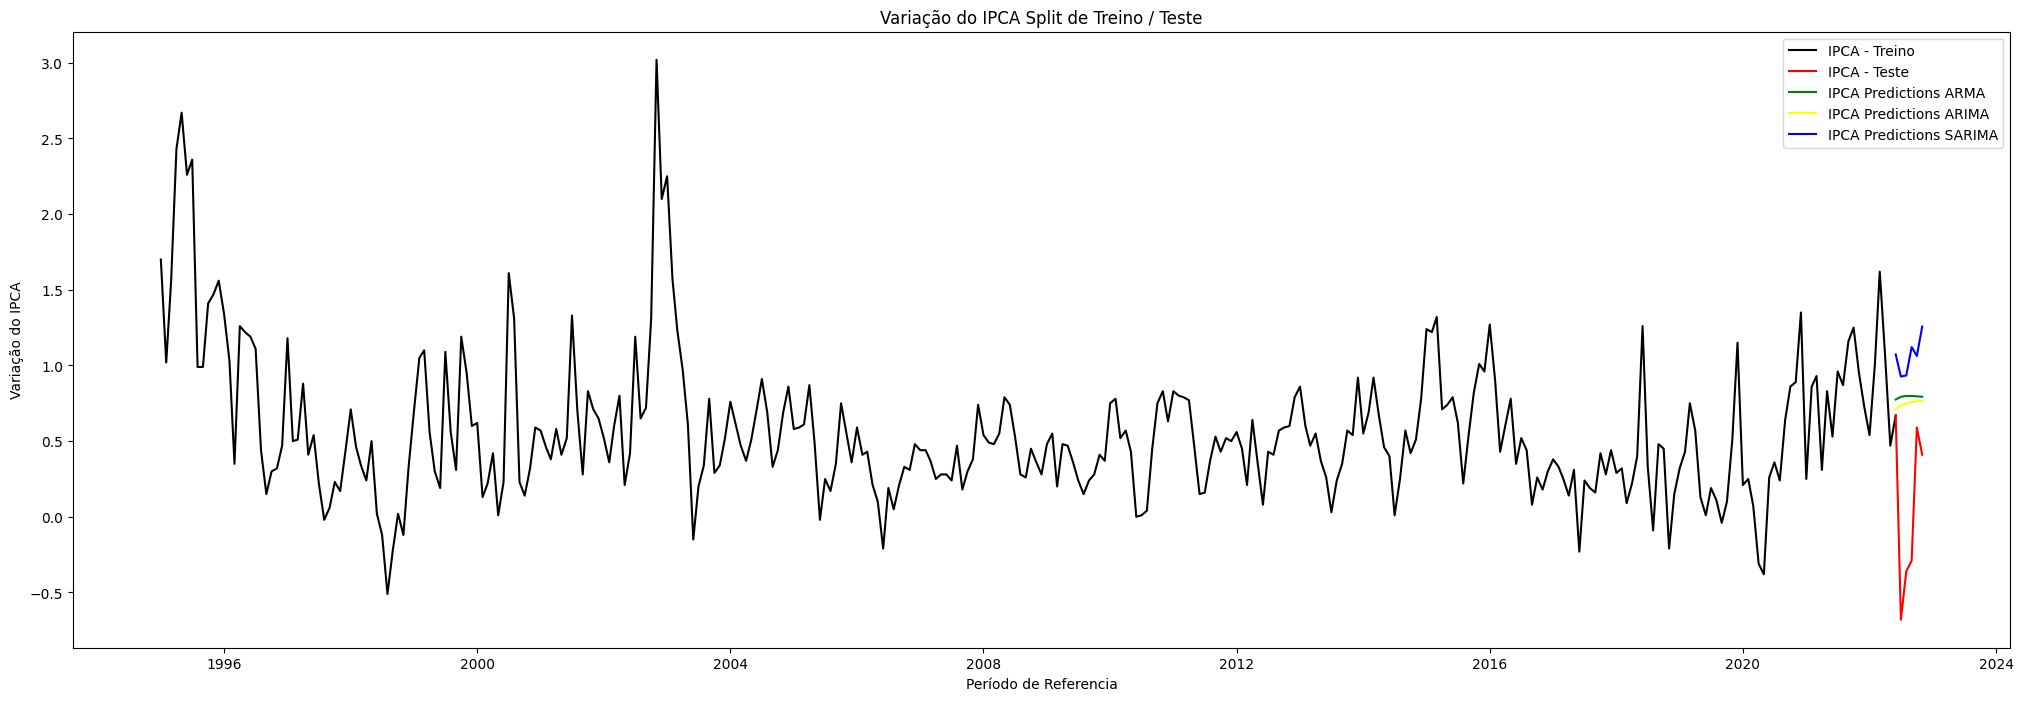

In [49]:
plt.figure(figsize=(25, 8))
plt.plot(train.index, train, label="IPCA - Treino", color='black')
plt.plot(test.index, test, label="IPCA - Teste", color='red')

plt.plot(y_pred_out, color='green', label = 'IPCA Predictions ARMA')
plt.plot(y_pred_out_arima, color='Yellow', label = 'IPCA Predictions ARIMA')
plt.plot(y_pred_out_sarima, color='Blue', label = 'IPCA Predictions SARIMA')

plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")

plt.title("Variação do IPCA Split de Treino / Teste")
plt.legend()
plt.show()

#### Escolhido o modelo Sarima para efetuar as previsões

In [50]:
prediction = SARIMAXmodel.predict(start='2022-11-01',end='2028-12-01')

In [51]:
prediction

2022-11-01    1.062579
2022-12-01    1.256928
2023-01-01    1.181998
2023-02-01    1.096006
2023-03-01    0.935770
                ...   
2028-08-01    1.005243
2028-09-01    1.378011
2028-10-01    1.447574
2028-11-01    1.039659
2028-12-01    1.372934
Freq: MS, Name: predicted_mean, Length: 74, dtype: float64

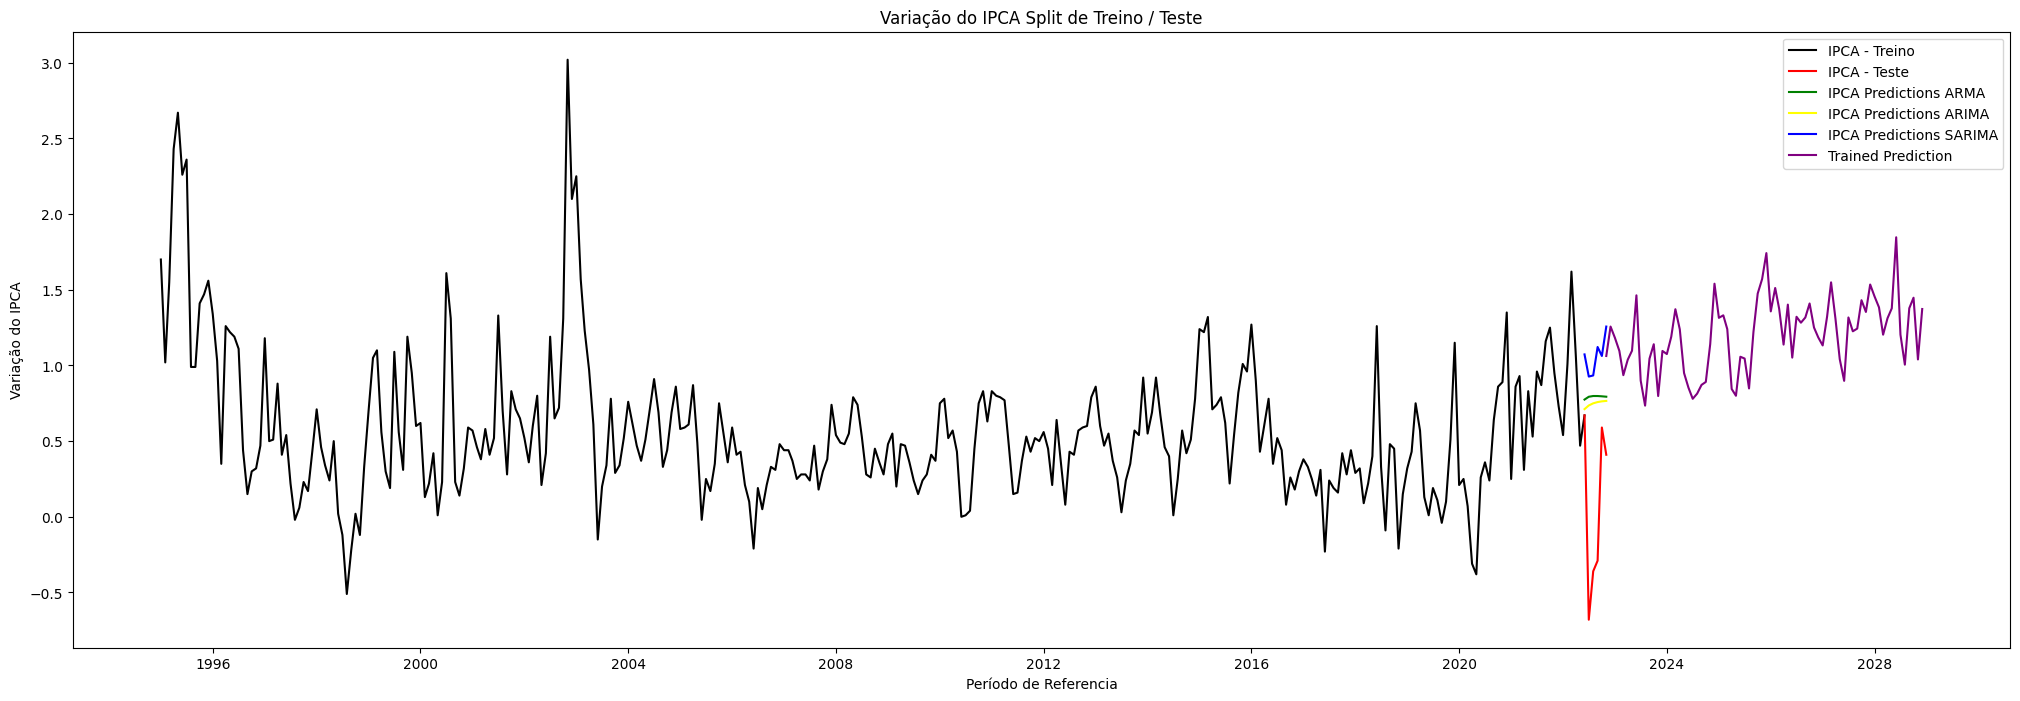

In [52]:
plt.figure(figsize=(25, 8))
plt.plot(train.index, train, label="IPCA - Treino", color='black')
plt.plot(test.index, test, label="IPCA - Teste", color='red')

plt.plot(y_pred_out, color='green', label = 'IPCA Predictions ARMA')
plt.plot(y_pred_out_arima, color='Yellow', label = 'IPCA Predictions ARIMA')
plt.plot(y_pred_out_sarima, color='Blue', label = 'IPCA Predictions SARIMA')
plt.plot(prediction, color='purple', label = 'Trained Prediction')

plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")

plt.title("Variação do IPCA Split de Treino / Teste")
plt.legend()
plt.show()

# Auto Arima

In [56]:
sarima_model = auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore', m=12, trace=True)

KeyboardInterrupt: 

In [55]:
sarima_model

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)